## If I Could Churn Back Time

... we wouldn't need these models.

# Overview

For my capstone project, I have chosen to continue in a similar vein to my Phase 3 project with entirely different data. Churn, which is what it is called when a customer stops doing business with a company, is one of the largest issues facing almost every industry today. In context of subscription industries, for example, "churn" is a massive ongoing issue, as it is infinitely cheaper to keep existing customers than to lure in new ones.

# Business Understanding

Therefore, establishing a procedure to keep customers from "churning" is of the utmost importance. The first step in this process is identifying the reasons behind customer churn, such as dissatisfaction, area of service provided, quality of service, and other such considerations. Following that, we will build a model that will accurately predict whether or not a customer will churn, and thereby provide the limitlessly valuable opportunity for a company to prevent that churn.

# Data Understanding

The data we've used for this endeavor comes to us from IBM, and is a publicly available dataset created for this exact purpose - to help deal with churn problems, and allow students like me to cut our teeth on such before we enter the wider world of data science. This sample data module tracks a fictional Telco company's customer churn based on a variety of possible factors, such as gender, monthly charges, and usage information, as well as whether the customer churned or not. Due to the nature of the data we used, any location based features were excluded because the data was all centered in California specifically.

# Data Preparation

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

Our first step in data preparation is to load in the data and do some basic exploration to ascertain what exactly we're working with and what of that data is and is not necessary.

In [78]:
churn_df = pd.read_excel('Data/CustomerChurn.xlsx')

In [79]:
churn_df.head()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [80]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LoyaltyID          7043 non-null   int64  
 1   Customer ID        7043 non-null   object 
 2   Senior Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure             7043 non-null   int64  
 6   Phone Service      7043 non-null   object 
 7   Multiple Lines     7043 non-null   object 
 8   Internet Service   7043 non-null   object 
 9   Online Security    7043 non-null   object 
 10  Online Backup      7043 non-null   object 
 11  Device Protection  7043 non-null   object 
 12  Tech Support       7043 non-null   object 
 13  Streaming TV       7043 non-null   object 
 14  Streaming Movies   7043 non-null   object 
 15  Contract           7043 non-null   object 
 16  Paperless Billing  7043 

As we can see, this dataframe contains information such as whether the user is a senior citizen, whether the user has a partner, and other such features that could be useful in modeling. We have a few other datasets to choose from as well, to ensure we are getting a good variance in features when we begin to model and determine which of these features impact customer churn the most.

In [81]:
telco_churn = pd.read_excel('Data/Telco_customer_churn.xlsx')

In [82]:
telco_churn.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [83]:
telco_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

This dataset contains similar information, but there are additional features such as gender, location information, monthly charges, and, very importantly, a churn reason. Let's continue to explore our data so that we can decide which features are or are not important per dataset, and bind everything together into one usable dataframe for modeling.

In [84]:
services_df = pd.read_excel('Data/Telco_customer_churn_services.xlsx')

In [85]:
services_df.head()

,Service ID,Customer ID,Count,Quarter,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,...,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,IJKDQVSWH3522,8779-QRDMV,1,Q3,No,0,1,None,No,0.00,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65
1,BFKMZJAIE2285,7495-OOKFY,1,Q3,Yes,1,8,Offer E,Yes,48.85,...,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10
2,EIMVJQBMT7187,1658-BYGOY,1,Q3,No,0,18,Offer D,Yes,11.33,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88
3,EROZQXDUU4979,4598-XLKNJ,1,Q3,Yes,1,25,Offer C,Yes,19.76,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07
4,GEEYSJUHY6991,4846-WHAFZ,1,Q3,Yes,1,37,Offer C,Yes,6.33,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36


In [86]:
services_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Service ID                         7043 non-null   object 
 1   Customer ID                        7043 non-null   object 
 2   Count                              7043 non-null   int64  
 3   Quarter                            7043 non-null   object 
 4   Referred a Friend                  7043 non-null   object 
 5   Number of Referrals                7043 non-null   int64  
 6   Tenure in Months                   7043 non-null   int64  
 7   Offer                              7043 non-null   object 
 8   Phone Service                      7043 non-null   object 
 9   Avg Monthly Long Distance Charges  7043 non-null   float64
 10  Multiple Lines                     7043 non-null   object 
 11  Internet Service                   7043 non-null   objec

This dataset contains information about the services each user engaged, and also information about the revenue gained from each of those customers.

In [87]:
status_df = pd.read_excel('Data/Telco_customer_churn_status.xlsx')

In [88]:
status_df.head()

,Status ID,Customer ID,Count,Quarter,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
0,SWSORB1252,8779-QRDMV,1,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,SNAEQA8572,7495-OOKFY,1,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer
2,LMBQNN3714,1658-BYGOY,1,Q3,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer
3,VRZYZI9978,4598-XLKNJ,1,Q3,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services
4,FDNAKX1688,4846-WHAFZ,1,Q3,2,Churned,Yes,1,67,2793,Price,Extra data charges


In [89]:
status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Status ID           7043 non-null   object
 1   Customer ID         7043 non-null   object
 2   Count               7043 non-null   int64 
 3   Quarter             7043 non-null   object
 4   Satisfaction Score  7043 non-null   int64 
 5   Customer Status     7043 non-null   object
 6   Churn Label         7043 non-null   object
 7   Churn Value         7043 non-null   int64 
 8   Churn Score         7043 non-null   int64 
 9   CLTV                7043 non-null   int64 
 10  Churn Category      1869 non-null   object
 11  Churn Reason        1869 non-null   object
dtypes: int64(5), object(7)
memory usage: 660.4+ KB


This dataset once again contains a churn reason, and therefore might be very important to our future modeling. Now, it is time to pare down the bits we don't need from each dataframe (or omit them entirely) until we have ONE dataframe to work with that has our target "churn" and any available features we have deemed useful. To do this, we will begin by demonstrating the correlation of each column versus the churn column in the appropriate dataset, and go from there. In some cases, we will omit a dataset entirely if the information is repeated.

In [90]:
churn_df = churn_df.rename(columns={"Customer ID": "CustomerID"})

In [91]:
churn_df

,LoyaltyID,CustomerID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,810338,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,230811,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,155157,4801-JZAZL,No,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,731782,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In this first dataframe, we do not need LoytaltyID; it is an unnecessary piece of identifying information. We will keep everything else, as Customer ID is shared between all dataframes and these features may be very relevant to whether a customer will churn. We can also, wildly, drop the "churn" column, because we will be welding it to a dataframe that contains a churn column as well.

In [92]:
churn_df = churn_df.drop(['LoyaltyID', 'Churn'], axis=1)

In [93]:
churn_df

,CustomerID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6


Now, we move onto the telco_churn dataset and remove any unnecessary or repeated columns. As stated, any location information is worthless and can be removed. Any columns that already exist in the first dataframe will also be removed, to prevent any overlap when we merge these two dataframes together.

In [94]:
telco_churn

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,0,45,5306,NaN
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,One year,Yes,Mailed check,84.80,1990.5,No,0,59,2140,NaN
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,One year,Yes,Credit card (automatic),103.20,7362.9,No,0,71,5560,NaN
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,59,2793,NaN


In [95]:
telco_churn = telco_churn.drop(['Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Contract', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value'], axis=1)

In [96]:
telco_churn

,CustomerID,Gender,Churn Label,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,Male,Yes,86,3239,Competitor made better offer
1,9237-HQITU,Female,Yes,67,2701,Moved
2,9305-CDSKC,Female,Yes,86,5372,Moved
3,7892-POOKP,Female,Yes,84,5003,Moved
4,0280-XJGEX,Male,Yes,89,5340,Competitor had better devices
...,...,...,...,...,...,...
7038,2569-WGERO,Female,No,45,5306,NaN
7039,6840-RESVB,Male,No,59,2140,NaN
7040,2234-XADUH,Female,No,71,5560,NaN
7041,4801-JZAZL,Female,No,59,2793,NaN


In [97]:
churn_df2 = churn_df.merge(telco_churn, how="inner", on='CustomerID')

In [98]:
churn_df2

,CustomerID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Gender,Churn Label,Churn Score,CLTV,Churn Reason
0,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,Month-to-month,Yes,Electronic check,29.85,29.85,Female,No,27,3964,NaN
1,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,...,One year,No,Mailed check,56.95,1889.5,Male,No,61,3441,NaN
2,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,Male,Yes,86,3239,Competitor made better offer
3,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,No,...,One year,No,Bank transfer (automatic),42.30,1840.75,Male,No,66,4307,NaN
4,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,Female,Yes,67,2701,Moved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,One year,Yes,Mailed check,84.80,1990.5,Male,No,59,2140,NaN
7039,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,One year,Yes,Credit card (automatic),103.20,7362.9,Female,No,71,5560,NaN
7040,4801-JZAZL,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,Month-to-month,Yes,Electronic check,29.60,346.45,Female,No,59,2793,NaN
7041,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,Month-to-month,Yes,Mailed check,74.40,306.6,Male,Yes,77,5839,Competitor offered more data


In [99]:
services_df = services_df.rename(columns={"Customer ID": "CustomerID"})

In [100]:
services_df = services_df.drop(['Service ID', 'Count', 'Quarter', 'Tenure in Months', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charge', 'Total Charges'], axis=1)

In [101]:
churn_df3 = churn_df2.merge(services_df, how="inner", on='CustomerID')

In [102]:
churn_df3

,CustomerID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Avg Monthly Long Distance Charges,Internet Type,Avg Monthly GB Download,Premium Tech Support,Streaming Music,Unlimited Data,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,0.00,DSL,10,No,No,Yes,0.00,0,0.00,29.85
1,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,...,17.09,DSL,16,No,No,Yes,0.00,0,581.06,2470.56
2,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,...,10.47,DSL,21,No,No,Yes,0.00,0,20.94,129.09
3,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,No,...,0.00,DSL,10,Yes,No,Yes,0.00,0,0.00,1840.75
4,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,No,...,9.12,Fiber Optic,51,No,No,Yes,0.00,0,18.24,169.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,36.05,Cable,24,Yes,Yes,Yes,48.23,0,865.20,2807.47
7039,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,29.66,Fiber Optic,59,No,Yes,Yes,45.38,0,2135.52,9453.04
7040,4801-JZAZL,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,0.00,DSL,17,No,No,Yes,27.24,0,0.00,319.21
7041,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,10.61,Fiber Optic,8,No,No,No,0.00,20,42.44,369.04


In [103]:
churn_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   CustomerID                         7043 non-null   object 
 1   Senior Citizen                     7043 non-null   object 
 2   Partner                            7043 non-null   object 
 3   Dependents                         7043 non-null   object 
 4   Tenure                             7043 non-null   int64  
 5   Phone Service                      7043 non-null   object 
 6   Multiple Lines                     7043 non-null   object 
 7   Internet Service                   7043 non-null   object 
 8   Online Security                    7043 non-null   object 
 9   Online Backup                      7043 non-null   object 
 10  Device Protection                  7043 non-null   object 
 11  Tech Support                       7043 non-null   objec

In [104]:
status_df = status_df.rename(columns={"Customer ID": "CustomerID"})

In [105]:
status_df = status_df.drop(['Status ID', 'Count', 'Quarter', 'Customer Status', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Category', 'Churn Reason'], axis=1)

In [106]:
final_churn_df = churn_df3.merge(status_df, how="inner", on='CustomerID')

In [107]:
final_churn_df

,CustomerID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Internet Type,Avg Monthly GB Download,Premium Tech Support,Streaming Music,Unlimited Data,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score
0,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,DSL,10,No,No,Yes,0.00,0,0.00,29.85,3
1,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,...,DSL,16,No,No,Yes,0.00,0,581.06,2470.56,3
2,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,...,DSL,21,No,No,Yes,0.00,0,20.94,129.09,1
3,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,No,...,DSL,10,Yes,No,Yes,0.00,0,0.00,1840.75,3
4,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,No,...,Fiber Optic,51,No,No,Yes,0.00,0,18.24,169.89,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Cable,24,Yes,Yes,Yes,48.23,0,865.20,2807.47,3
7039,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,Fiber Optic,59,No,Yes,Yes,45.38,0,2135.52,9453.04,4
7040,4801-JZAZL,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,DSL,17,No,No,Yes,27.24,0,0.00,319.21,4
7041,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,Fiber Optic,8,No,No,No,0.00,20,42.44,369.04,2


In [108]:
final_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 37 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   CustomerID                         7043 non-null   object 
 1   Senior Citizen                     7043 non-null   object 
 2   Partner                            7043 non-null   object 
 3   Dependents                         7043 non-null   object 
 4   Tenure                             7043 non-null   int64  
 5   Phone Service                      7043 non-null   object 
 6   Multiple Lines                     7043 non-null   object 
 7   Internet Service                   7043 non-null   object 
 8   Online Security                    7043 non-null   object 
 9   Online Backup                      7043 non-null   object 
 10  Device Protection                  7043 non-null   object 
 11  Tech Support                       7043 non-null   objec

As we can see here, I am wee little baby data scientist, so we've gotten some columns that have been repeated throughout the process of stitching together various needed features from each dataframe. I'm sure there is a better way to do this in order to fix that, but what I will be doing is to remove the columns that end in y and rename the ones that end in x, and we should have a finished and workable dataframe to begin our modeling process.

In [109]:
#final_churn_df = final_churn_df.drop(['Gender_y', 'Churn Label_y', 'Churn Score_y', 'CLTV_y', 'Churn Reason_y', 'Referred a Friend_y', 'Number of Referrals_y', 'Avg Monthly Long Distance Charges_y', 'Internet Type_y', 'Avg Monthly GB Download_y', 'Premium Tech Support_y', 'Streaming Music_y', 'Unlimited Data_y', 'Total Refunds_y', 'Total Extra Data Charges_y', 'Total Long Distance Charges_y', 'Total Revenue_y'], axis=1)

In [110]:
final_churn_df

,CustomerID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Internet Type,Avg Monthly GB Download,Premium Tech Support,Streaming Music,Unlimited Data,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score
0,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,DSL,10,No,No,Yes,0.00,0,0.00,29.85,3
1,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,...,DSL,16,No,No,Yes,0.00,0,581.06,2470.56,3
2,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,...,DSL,21,No,No,Yes,0.00,0,20.94,129.09,1
3,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,No,...,DSL,10,Yes,No,Yes,0.00,0,0.00,1840.75,3
4,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,No,...,Fiber Optic,51,No,No,Yes,0.00,0,18.24,169.89,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Cable,24,Yes,Yes,Yes,48.23,0,865.20,2807.47,3
7039,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,Fiber Optic,59,No,Yes,Yes,45.38,0,2135.52,9453.04,4
7040,4801-JZAZL,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,DSL,17,No,No,Yes,27.24,0,0.00,319.21,4
7041,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,Fiber Optic,8,No,No,No,0.00,20,42.44,369.04,2


In [111]:
final_churn_df = final_churn_df.rename(columns={"CustomerID": "Customer ID", "Gender_x" : "Gender", "Churn Label_x" : "Churn Label", "Churn Score_x" : "Churn Score", "CLTV_x" : "CLTV", "Churn Reason_x" : "Churn Reason", "Referred a Friend_x" : "Referred a Friend", "Avg Monthly Long Distance Charges_x" : "Avg Monthly Long Distance Charges", "Internet Type_x" : "Internet Type", "Avg Monthly GB Download_x" : "Avg Monthly GB Download", "Premium Tech Support_x" : "Premium Tech Support", "Streaming Music_x" : "Streaming Music", "Unlimited Data_x" : "Unlimited Data", "Total Refunds_x" : "Total Refunds", "Total Extra Data Charges_x" : "Total Extra Data Charges", "Total Long Distance Charges_x" : "Total Long Distance Charges", "Total Revenue_x" : "Total Revenue"})

In [112]:
final_churn_df

,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Internet Type,Avg Monthly GB Download,Premium Tech Support,Streaming Music,Unlimited Data,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score
0,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,DSL,10,No,No,Yes,0.00,0,0.00,29.85,3
1,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,...,DSL,16,No,No,Yes,0.00,0,581.06,2470.56,3
2,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,...,DSL,21,No,No,Yes,0.00,0,20.94,129.09,1
3,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,No,...,DSL,10,Yes,No,Yes,0.00,0,0.00,1840.75,3
4,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,No,...,Fiber Optic,51,No,No,Yes,0.00,0,18.24,169.89,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Cable,24,Yes,Yes,Yes,48.23,0,865.20,2807.47,3
7039,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,Fiber Optic,59,No,Yes,Yes,45.38,0,2135.52,9453.04,4
7040,4801-JZAZL,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,DSL,17,No,No,Yes,27.24,0,0.00,319.21,4
7041,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,Fiber Optic,8,No,No,No,0.00,20,42.44,369.04,2


In [113]:
final_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 37 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Senior Citizen                     7043 non-null   object 
 2   Partner                            7043 non-null   object 
 3   Dependents                         7043 non-null   object 
 4   Tenure                             7043 non-null   int64  
 5   Phone Service                      7043 non-null   object 
 6   Multiple Lines                     7043 non-null   object 
 7   Internet Service                   7043 non-null   object 
 8   Online Security                    7043 non-null   object 
 9   Online Backup                      7043 non-null   object 
 10  Device Protection                  7043 non-null   object 
 11  Tech Support                       7043 non-null   objec

As we can see, our several dataframes have been stitched into one workable dataframe with 35 features (discounting Customer ID and Churn Label) and we can now move forward with our preparations for modeling and the process thereof.

# Analysis

Now it is time to establish correlation between our features (those 35 mentioned) and our target ("Churn Label") so that we can proceed with modeling those features against that target in order to predict whether a customer will churn with the highest possible recall. Remember that recall is our important metric here rather than accuracy because it measures, in this context, which customers are predicted to churn versus which customers actually churned.

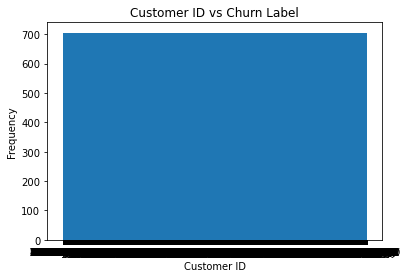

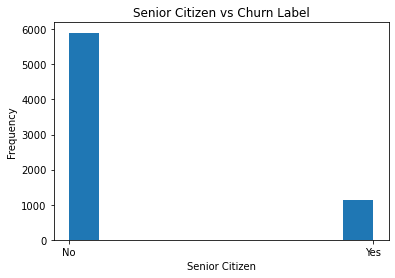

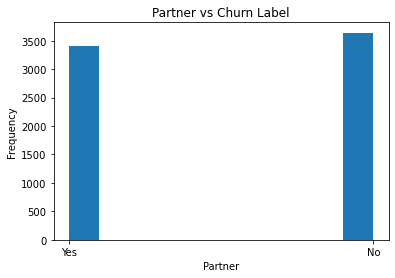

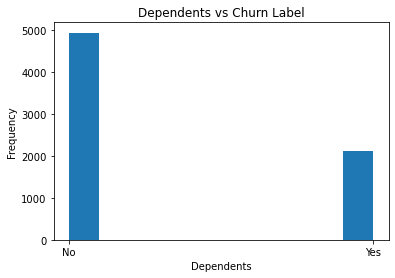

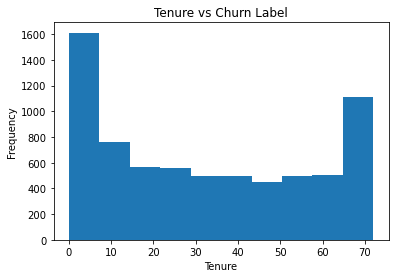

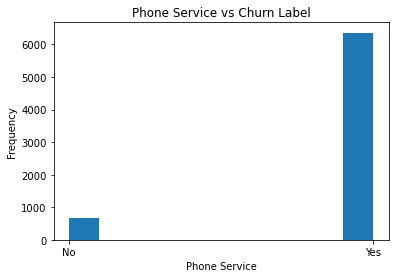

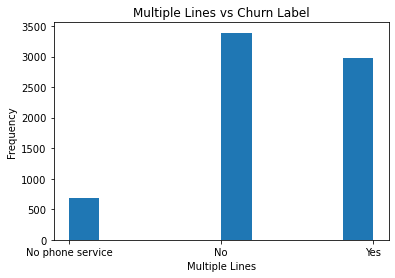

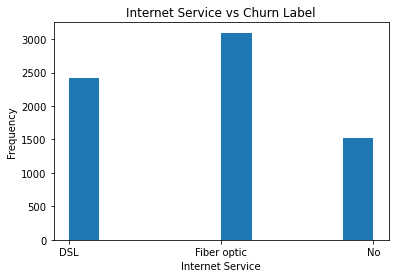

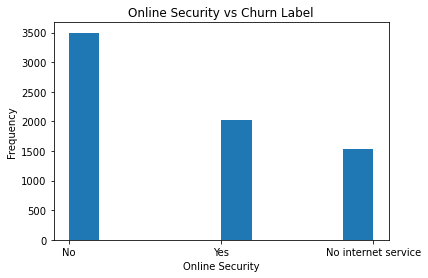

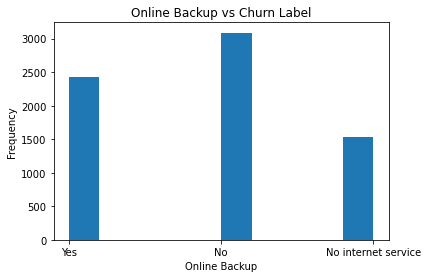

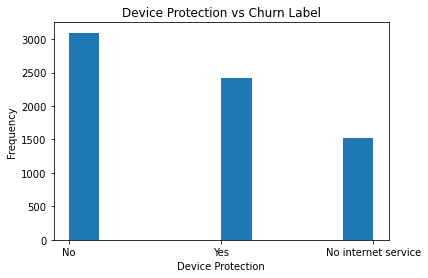

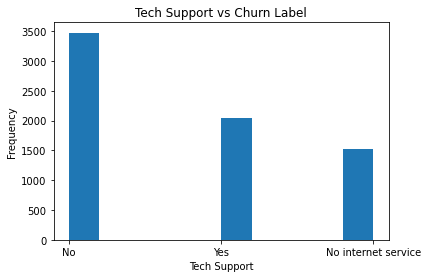

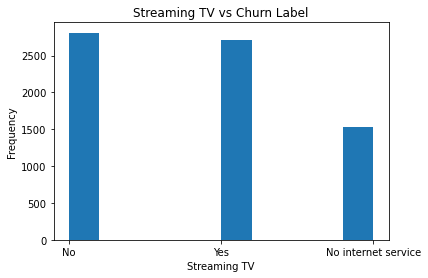

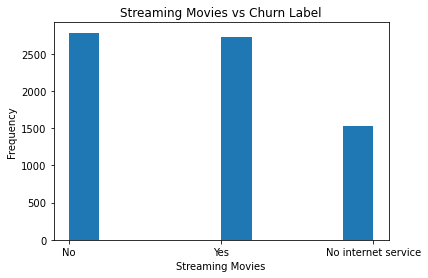

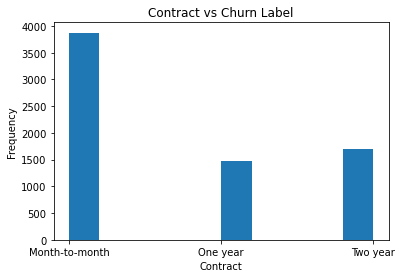

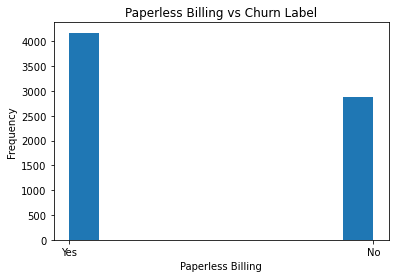

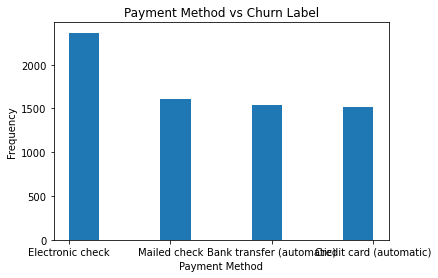

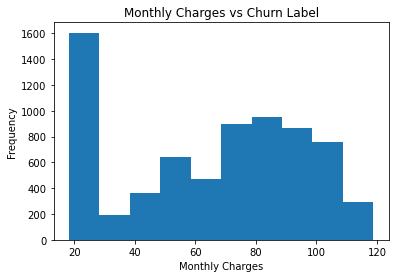

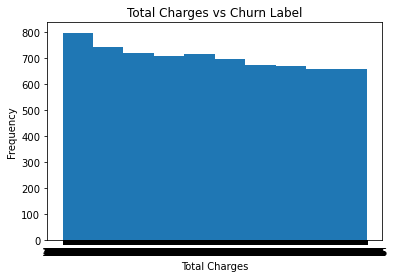

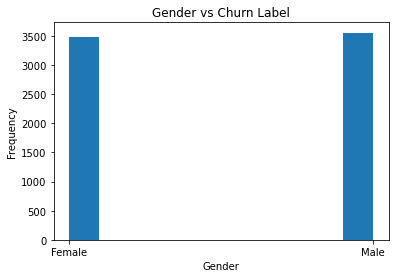

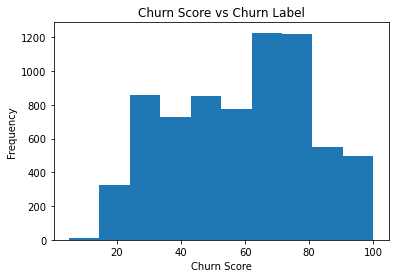

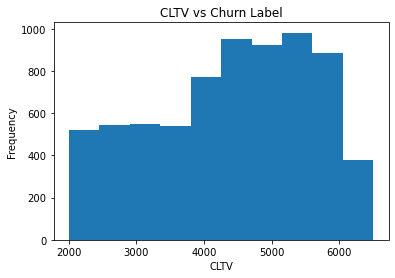

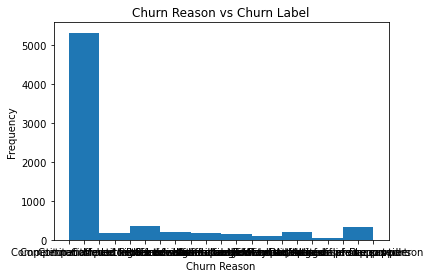

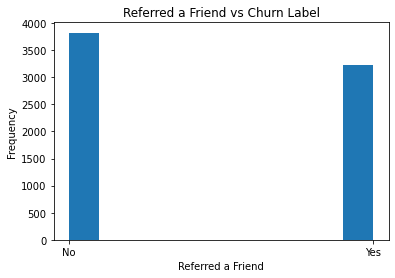

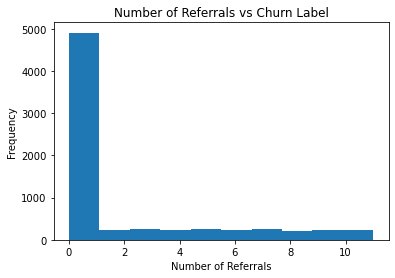

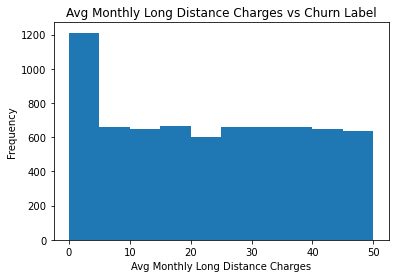

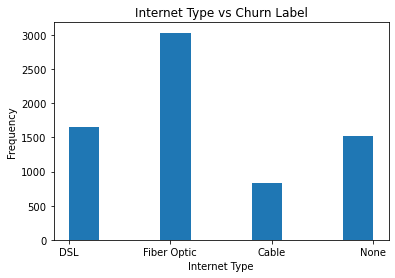

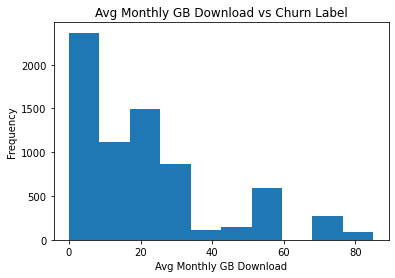

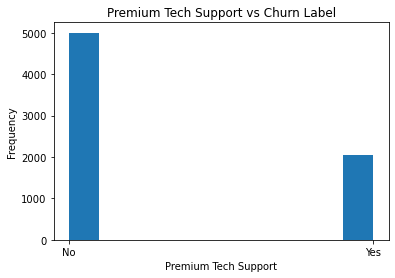

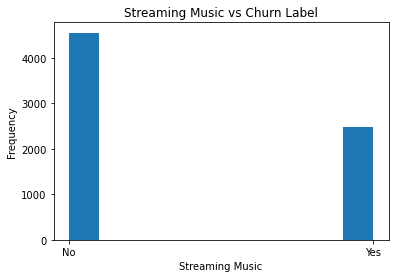

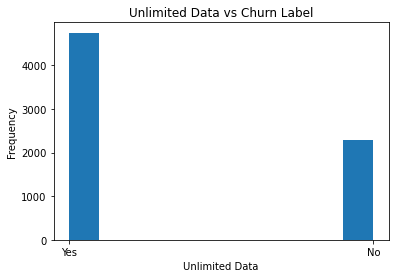

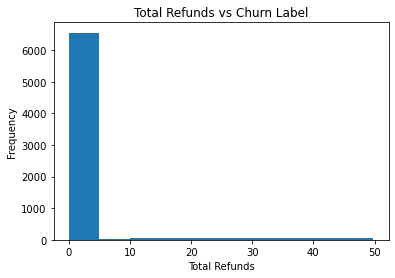

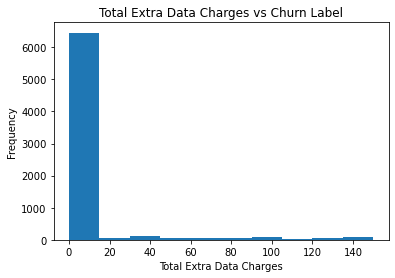

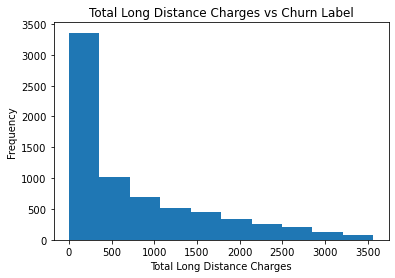

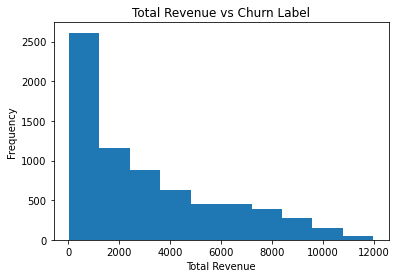

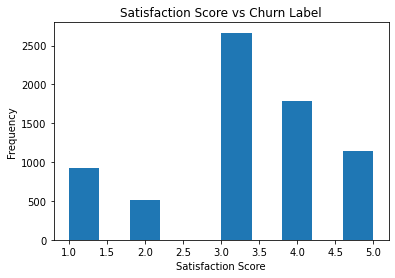

In [114]:
def plot_histograms(dataframe, target_column):
    for column in dataframe.columns:
        if column == target_column:
            continue
        plt.hist(dataframe[column])
        plt.title(f"{column} vs {target_column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

# Example usage:
plot_histograms(final_churn_df, "Churn Label")

After we've decided which features are most relevant, we can move on to splitting our data into a train/test set and define our features versus our targets. Then, we may begin the modeling process with a dummy model, which is a model that simply chooses "yes" each time. Our goal with our "final model" is to not only beat the dummy model but to outperform any other model iterations in context of recall.

In [115]:
X = final_churn_df.drop('Churn Label', axis=1)
y = final_churn_df['Churn Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [116]:
X_train

,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Internet Type,Avg Monthly GB Download,Premium Tech Support,Streaming Music,Unlimited Data,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score
6607,7242-QZLXF,No,No,Yes,1,No,No phone service,DSL,No,No,...,Cable,51,No,No,No,0.0,10,0.00,35.30,2
2598,8325-QRPZR,No,No,No,7,Yes,No,Fiber optic,No,No,...,Fiber Optic,10,No,No,No,0.0,10,210.42,745.42,3
2345,7874-ECPQJ,No,No,Yes,4,Yes,No,No,No internet service,No internet service,...,None,0,No,No,No,0.0,0,109.48,194.98,5
4093,2476-YGEFM,No,No,No,29,Yes,Yes,Fiber optic,No,No,...,Fiber Optic,42,No,No,Yes,0.0,0,203.29,2418.54,3
693,2276-YDAVZ,No,No,No,3,Yes,Yes,Fiber optic,No,No,...,Fiber Optic,10,No,No,Yes,0.0,0,79.56,350.26,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0684-AOSIH,No,Yes,No,1,Yes,No,Fiber optic,Yes,No,...,Cable,5,No,Yes,Yes,0.0,0,12.04,107.04,1
5191,5982-PSMKW,No,Yes,Yes,23,Yes,Yes,DSL,Yes,Yes,...,Cable,51,Yes,Yes,Yes,0.0,0,643.31,2841.61,4
5226,8044-BGWPI,No,Yes,Yes,12,Yes,No,No,No internet service,No internet service,...,None,0,No,No,No,0.0,0,406.80,712.85,4
5390,7450-NWRTR,Yes,No,No,12,Yes,Yes,Fiber optic,No,No,...,Fiber Optic,26,No,No,Yes,0.0,0,262.68,1462.83,3


In [117]:
X_test

,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Internet Type,Avg Monthly GB Download,Premium Tech Support,Streaming Music,Unlimited Data,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score
185,1024-GUALD,No,Yes,No,1,No,No phone service,DSL,No,No,...,DSL,29,No,Yes,Yes,0.0,0,0.00,24.80,1
2715,0484-JPBRU,No,No,No,41,Yes,Yes,No,No internet service,No internet service,...,None,0,No,No,No,0.0,0,1689.61,2686.06,4
3825,3620-EHIMZ,No,Yes,Yes,52,Yes,No,No,No internet service,No internet service,...,None,0,No,No,No,0.0,0,513.24,1544.94,5
1807,6910-HADCM,No,No,No,1,Yes,No,Fiber optic,No,No,...,Cable,9,No,No,Yes,0.0,0,7.26,83.61,2
132,8587-XYZSF,No,No,No,67,Yes,No,DSL,No,No,...,DSL,8,Yes,No,Yes,0.0,0,2182.86,5442.96,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,4581-SSPWD,No,No,No,3,Yes,Yes,Fiber optic,No,No,...,Fiber Optic,23,No,No,No,0.0,10,15.60,271.90,1
2301,4813-HQMGZ,No,Yes,No,8,Yes,Yes,Fiber optic,No,No,...,Fiber Optic,4,Yes,Yes,No,0.0,0,79.04,822.79,3
5121,4903-CNOZC,No,No,No,29,Yes,Yes,DSL,No,Yes,...,DSL,47,No,Yes,Yes,0.0,0,836.07,2800.67,4
677,0822-GAVAP,No,No,No,2,No,No phone service,DSL,No,No,...,DSL,76,No,Yes,Yes,0.0,0,0.00,62.25,1


Performing a train/test split in this way will allow us to continue our modeling and validation processes without worrying about data leakage. This is of the utmost importance, as training a model on testing data will inherently mean that that model is "cheating", so to speak; of course it will do well on testing data it's already seen. Our next step is to scale our numeric columns and encode our categorical columns so that we may proceed with modeling.

First we must separate our features into numeric and categorical.

In [118]:
num_feats = ['Tenure', 'Monthly Charges', 'Churn Score', 'CLTV', 'Number of Referrals', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Total Refunds', 'Total Extra Data Charges', 'Total Extra Long Distance Charges', 'Total Revenue', 'Satisfaction Score']
cat_feats = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Total Charges', 'Gender', 'Churn Label', 'Churn Reason', 'Referred a Friend', 'Internet Type', 'Premium Tech Support', 'Streaming Music', 'Unlimited Data']

In [120]:
prep_pipeline = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), cat_feats),
        ('numeric', StandardScaler(), num_feats)
    ],
    remainder='passthrough')

In [121]:
standard_pipeline.fit_transform(X_train)

ValueError: A given column is not a column of the dataframe

# Model Recommendation

# Conclusion

# Next Steps